In [1]:
import numpy as np 
from matplotlib import pyplot as plt

# Bellman Distance Computation (Vectorized Form)

Problem: computation of DTW distance takes too much time. We need a new algorithm to compute (even approximately) the projection of the trajectory on the 2D plane.

In [2]:
# Load a sample trajectory 

trajs = np.load('stx/2017-01-01 10_00_00.npz', allow_pickle=True)['arr_0']
print('Trajs' , trajs.shape)

Trajs (3, 2, 2000)


In [3]:
# Load the ROI mask from file 

# Add a directory to the path
import sys
sys.path.append('../wx')

from roi import WX_ROI
print('WX Region of Interest Coordinate Range: ', WX_ROI)

WX Region of Interest Coordinate Range:  [(-99.973496106, -93.973496106), (29.584330996, 35.584330996)]


In [4]:
# Create a grid of points in the ROI
x = np.linspace(WX_ROI[0][0], WX_ROI[0][1], 100)
y = np.linspace(WX_ROI[1][0], WX_ROI[1][1], 100)
xx, yy = np.meshgrid(x, y)

In [15]:
# Create a shadow for the trajectory on the grid
def create_trajectory_mask(trajectory, xx, yy):
    # Create a mask for the trajectory
    traj_mask = np.zeros_like(xx)
    # Project the trajectory onto the grid
    for i in range(trajectory.shape[1]):
        traj_mask[np.argmin(np.abs(xx[0,:] - trajectory[1,i])), np.argmin(np.abs(yy[:,0] - trajectory[0,i]))] = 1
        
    return traj_mask

In [64]:
def shift_mask(mask, shift):
    # Shift the mask by the shift vector
    mask_shift = np.zeros_like(mask)
    
    # Bound the shift vector to the mask size
    shift_0_limit = (0, mask.shape[0])
    shift_1_limit = (0, mask.shape[1])
    
    shift_0 = np.abs(shift[0])
    shift_1 = np.abs(shift[1])
    
    if shift_0 > shift_0_limit[1]:
        shift_0 = shift_0_limit[1]
    if shift_0 < shift_0_limit[0]:
        shift_0 = shift_0_limit[0]
    if shift_1 > shift_1_limit[1]:
        shift_1 = shift_1_limit[1]
    if shift_1 < shift_1_limit[0]:
        shift_1 = shift_1_limit[0]
        
    shift[0] = np.sign(shift[0]) * shift_0
    shift[1] = np.sign(shift[1]) * shift_1
    
    # First index range for the mask
    if shift[0] >= 0:
        first_index_range_0 = np.arange(0, mask.shape[0] - shift[0])
        second_index_range_0 = np.arange(shift[0], mask.shape[0])
    else:
        first_index_range_0 = np.arange(-shift[0], mask.shape[0])
        second_index_range_0 = np.arange(0, mask.shape[0] + shift[0])
    
    # Second index range for the mask
    if shift[1] >= 0:
        first_index_range_1 = np.arange(0, mask.shape[1] - shift[1])
        second_index_range_1 = np.arange(shift[1], mask.shape[1])
    else:
        first_index_range_1 = np.arange(-shift[1], mask.shape[1])
        second_index_range_1 = np.arange(0, mask.shape[1] + shift[1])
    
    mask_shift = np.zeros_like(mask)
    mask_shift[first_index_range_0, :] = mask[second_index_range_0, :]
    mask_shift[:, first_index_range_1] = mask_shift[:, second_index_range_1]
    
    return mask_shift

In [56]:
mask_0 = create_trajectory_mask(trajs[0,:,:], xx, yy)

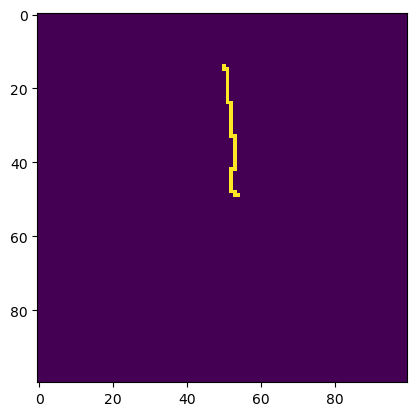

In [57]:
plt.imshow(mask_0)

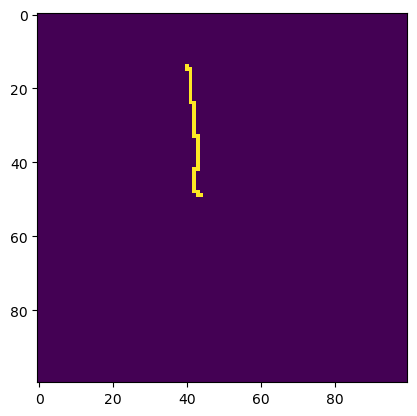

In [72]:
plt.imshow(shift_mask(mask_0, [0,10]))

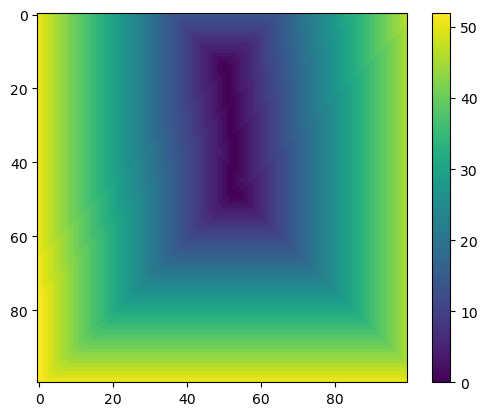

In [109]:
def ds_dist_field_one_step(mask, orig_mask, iter=0):
    shift_options = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]] # 8 neighbors
    shift_options_arr = np.array(shift_options)
    # recall: -1 = move down(pan up), or move right(pan left)
    #         1 = move up(pan down), or move left(pan right)
    # the first index corresponds to the vertical shift, the second index corresponds to the horizontal shift
    
    # Build the mask_stack to store all shifted masks
    mask_stack = np.empty((8, mask.shape[0], mask.shape[1])) # to store all shifted masks
    for i, shift_vector in enumerate(shift_options):
        shifted_mask = shift_mask(mask, shift_vector)
        mask_stack[i,:,:] = shifted_mask
        
    new_mask = np.min(mask_stack, axis=0)
    
    # Handling edges and corners ================================================
    # For the top edge, we only minimize for move up
    shift_options_index = np.where(np.array(shift_options)[:,0] == 1)[0]
    new_mask[0, :] = np.min(mask_stack[shift_options_index, 0, :], axis=0)
    
    # For the bottom edge, we only minimize for move down
    shift_options_index = np.where(np.array(shift_options)[:,0] == -1)[0]
    new_mask[-1, :] = np.min(mask_stack[shift_options_index, -1, :], axis=0)
    
    # For the left edge, we only minimize for move right
    shift_options_index = np.where(np.array(shift_options)[:,1] == 1)[0]
    new_mask[:, 0] = np.min(mask_stack[shift_options_index, :, 0], axis=0)
    
    # For the right edge, we only minimize for move left
    shift_options_index = np.where(np.array(shift_options)[:,1] == -1)[0]
    new_mask[:, -1] = np.min(mask_stack[shift_options_index, :, -1], axis=0)
    
    # For the top left corner, we only minimize for move up and move right
    shift_options_index = np.where(((shift_options_arr[:,0] == 1) & (shift_options_arr[:,1] >= 0))
                                   | ((shift_options_arr[:,0] >= 0) & (shift_options_arr[:,1] == 1)))[0]
    new_mask[0, 0] = np.min(mask_stack[shift_options_index, 0, 0], axis=0)
    
    # For the top right corner, we only minimize for move up and move left
    shift_options_index = np.where(((shift_options_arr[:,0] == 1) & (shift_options_arr[:,1] <= 0))
                                   |((shift_options_arr[:,0] >= 0) & (shift_options_arr[:,1] == -1)))[0]
    new_mask[0, -1] = np.min(mask_stack[shift_options_index, 0, -1], axis=0)
    
    # For the bottom left corner, we only minimize for move down and move left
    shift_options_index = np.where(((shift_options_arr[:,0] == -1) & (shift_options_arr[:,1] >= 0))
                                   |((shift_options_arr[:,0] <= 0)&(shift_options_arr[:,1] == 1)))[0]
    new_mask[-1, 0] = np.min(mask_stack[shift_options_index, -1, 0], axis=0)
    
    # For the bottom right corner, we only minimize for move down and move right
    shift_options_index = np.where((shift_options_arr[:,0] == -1) & (shift_options_arr[:,1] <= 0)
                                   |((shift_options_arr[:,0] <= 0) & (shift_options_arr[:,1] == -1)))[0]
    new_mask[-1, -1] = np.min(mask_stack[shift_options_index, -1, -1], axis=0)
    
    # Bellman update ============================================================
    new_mask = new_mask + 1
    
    # Zeroing out the original mask
    new_mask[np.where(orig_mask == 1)] = 0
    
    return new_mask

mask_100 = mask_0.copy()
for i in range(100):
    mask_100 = ds_dist_field_one_step(mask_100, mask_0, iter = i)
    
plt.imshow(mask_100)
plt.colorbar()

In [112]:
def get_distance(dist_field_x, mask_target):
    return np.where(mask_target == 1, dist_field_x, 0).sum()

In [110]:
mask_target = create_trajectory_mask(trajs[1,:,:], xx, yy)

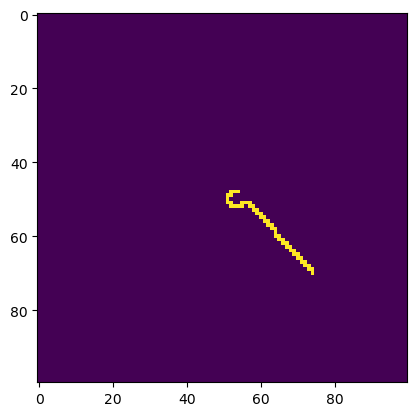

In [111]:
plt.imshow(mask_target)

In [113]:
get_distance(mask_100, mask_target)

460.0